In [1]:
import pandas as pd

In [2]:
# Retweet networks
dtype = {'source': str,
         'target': str,
         'weight': int}

observation_net_df = pd.read_csv('data/observation_retweet_network.csv', dtype=dtype)
evaluation_net_df = pd.read_csv('data/evaluation_retweet_network.csv', dtype=dtype)

In [3]:
# Load rankings
dtype = {'author_id': str}
popularity_rank_df = pd.read_csv('data/popularity_rank.csv', index_col='author_id', dtype=dtype)
influence_rank_df = pd.read_csv('data/influence_rank.csv', index_col='author_id', dtype=dtype)
fib_rank_df = pd.read_csv('data/fib_rank.csv', index_col='author_id', dtype=dtype)
tfib_rank_df = pd.read_csv('data/tfib_rank.csv', index_col='author_id', dtype=dtype)
retweets_rank_df = pd.read_csv('data/retweets_rank.csv', index_col='author_id', dtype=dtype)
compound_rank_df = pd.read_csv('data/compound_rank.csv', index_col='author_id', dtype=dtype)
optimal_rank_df = pd.read_csv('data/optimal_rank.csv', index_col='author_id', dtype=dtype)

In [4]:
# Dismantling procedure by given ranking
def network_dismantle(network_df, ranking_df):
    
    print("Dismantling...")
    
    full_misinformation = network_df.weight.sum()

    dismantled_network_df = network_df.copy()

    network_sources = set(network_df.source.unique())
    
    track = [(None, 1.0)]
    
    for author, _ in ranking_df.itertuples(): # reverse rank -> ranking_df.iloc[::-1].itertuples()

        if author in network_sources:

            # The network without the current author as source
            dismantled_network_df = dismantled_network_df[dismantled_network_df.source != author]
    
            # The ratio of current remaining misinformation in the network
            remaining_misinformation = dismantled_network_df.weight.sum() / full_misinformation
            
            track.append((author, remaining_misinformation))

    # Adjust sequence to have same lenght
    n_residual_sources = dismantled_network_df.source.nunique()
    track += [track[-1] for _ in range(n_residual_sources)]
    
    return track

# Test
# network_dismantle(observation_net_df, popularity_rank_df)
from utils import network_dismantle

### Analysis

In [5]:
# evaluation period
print("Popularity dismantle...", end='')
popularity_dismantle = network_dismantle(evaluation_net_df, popularity_rank_df)
print("Done")
print("Influence dismantle...", end='')
influence_dismantle = network_dismantle(evaluation_net_df, influence_rank_df)
print("Done")
print("FIB dismantle...", end='')
fib_dismantle = network_dismantle(evaluation_net_df, fib_rank_df)
print("Done")
print("T-FIB dismantle...", end='')
tfib_dismantle = network_dismantle(evaluation_net_df, tfib_rank_df)
print("Done")
print("Retweets dismantle...", end='')
retweets_dismantle = network_dismantle(evaluation_net_df, retweets_rank_df)
print("Done")
print("Compound dismantle...", end='')
compound_dismantle = network_dismantle(evaluation_net_df, compound_rank_df)
print("Done")
# Ground truth
optimal_dismantle = network_dismantle(evaluation_net_df, optimal_rank_df)

Popularity dismantle...Done
Influence dismantle...Done
FIB dismantle...Done
T-FIB dismantle...Done
Retweets dismantle...Done
Compound dismantle...Done


In [6]:
# observation period
#popularity_dismantle = network_dismantle(observation_net_df, popularity_rank_df)
#influence_dismantle = network_dismantle(observation_net_df, influence_rank_df)
#fib_dismantle = network_dismantle(observation_net_df, fib_rank_df)
#retweets_dismantle = network_dismantle(observation_net_df, retweets_rank_df)
#fraction_dismantle = network_dismantle(observation_net_df, fraction_rank_df)
#optimal_dismantle = network_dismantle(observation_net_df, optimal_rank_df)

In [7]:
# Paper results
dismantle_df = pd.DataFrame({'Popularity': [y for _, y in popularity_dismantle],
                             'Influence': [y for _, y in influence_dismantle],
                             'FIB-index': [y for _, y in fib_dismantle],
                             'Optimal': [y for _, y in optimal_dismantle]
                            })

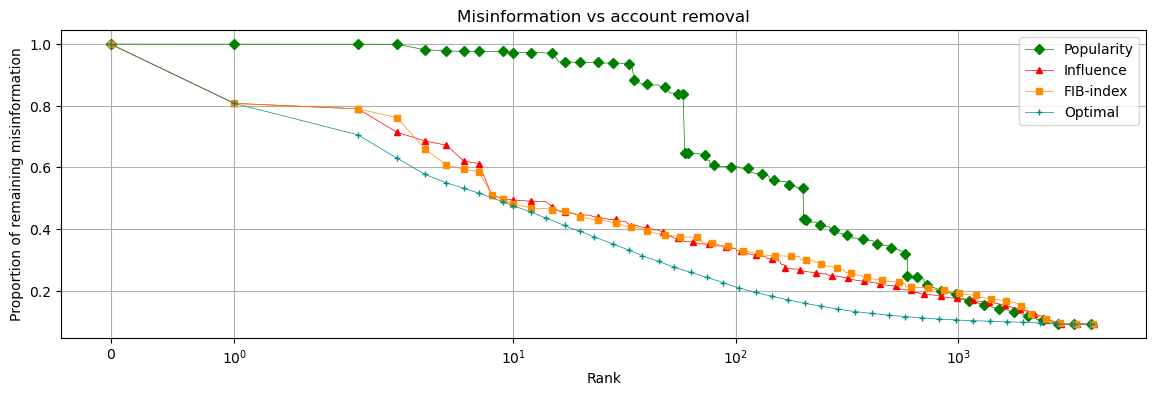

In [8]:
colors = ['green', 'red', 'darkorange', 'darkcyan']
styles = ['D-', '^-', 's-' ,'+-']
ax = dismantle_df.plot.line(logx='sym',
                            figsize=(14, 4),
                            grid=True,
                            color=colors,
                            style=styles,
                            linewidth=0.5,
                            markevery=0.015,
                            ms=5,
                            title='Misinformation vs account removal');

ax.set_ylabel("Proportion of remaining misinformation");

ax.set_xlabel("Rank");

In [9]:
print(len(compound_dismantle))
print(len(fib_dismantle))
print(len(retweets_dismantle))
print(len(optimal_dismantle))

4217
4217
4217
4217


In [10]:
dismantle_df = pd.DataFrame({'Popularity': [y for _, y in popularity_dismantle],
                             'Influence': [y for _, y in influence_dismantle],
                             'FIB-index': [y for _, y in fib_dismantle],
                             'Retweets': [y for _, y in retweets_dismantle],
                             'Compound': [y for _, y in compound_dismantle],
                             'Optimal': [y for _, y in optimal_dismantle]
                            })

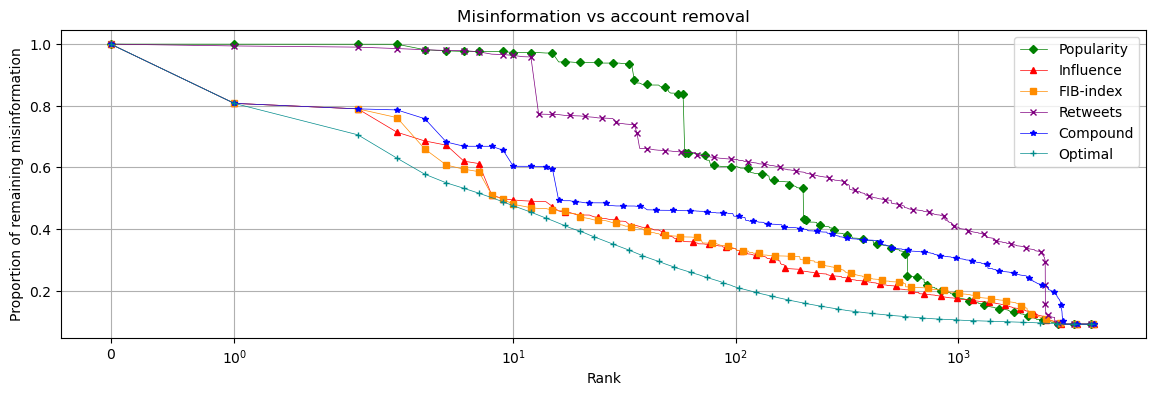

In [11]:
colors = ['green', 'red', 'darkorange', 'purple', 'blue', 'darkcyan']
styles = ['D-', '^-', 's-', 'x-', '*-','+-']
ax = dismantle_df.plot.line(logx='sym',
                            figsize=(14, 4),
                            grid=True,
                            color=colors,
                            style=styles,
                            markevery=0.015,
                            linewidth=0.5,
                            ms=4,
                            title='Misinformation vs account removal');

ax.set_ylabel("Proportion of remaining misinformation");

ax.set_xlabel("Rank");

In [12]:
# TODO: Indagare su account "repeater" non postano disinformazione ma la ritrasmettono

In [13]:
dismantle_df

,Popularity,Influence,FIB-index,Retweets,Compound,Optimal
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999806,0.807851,0.807851,0.994088,0.807851,0.807851
2,0.999664,0.790070,0.790070,0.990261,0.790070,0.705920
3,0.999634,0.714246,0.761646,0.985620,0.786580,0.630096
4,0.981853,0.685980,0.659858,0.981801,0.758156,0.578137
...,...,...,...,...,...,...
4212,0.091930,0.091930,0.091930,0.091930,0.091930,0.091930
4213,0.091930,0.091930,0.091930,0.091930,0.091930,0.091930
4214,0.091930,0.091930,0.091930,0.091930,0.091930,0.091930
4215,0.091930,0.091930,0.091930,0.091930,0.091930,0.091930


## TeFIB comparisons

In [14]:
# Paper results
dismantle_df = pd.DataFrame({'Popularity': [y for _, y in popularity_dismantle],
                             #'Compound': [y for _, y in compound_dismantle],
                             'Influence': [y for _, y in influence_dismantle],
                             'TFIB-index\n(alpha=1/8)\n(interval = 5d)': [y for _, y in tfib_dismantle],
                             'FIB-index': [y for _, y in fib_dismantle],
                             'Optimal': [y for _, y in optimal_dismantle]
                            })

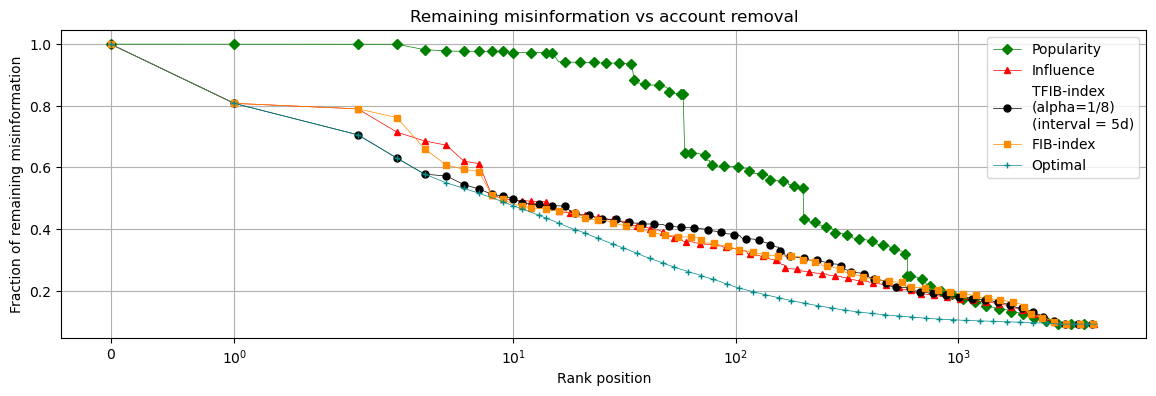

In [15]:
colors = ['green', 'red', 'black', 'darkorange', 'darkcyan']
styles = ['D-', '^-', 'o-', 's-' ,'+-']
ax = dismantle_df.plot.line(logx='sym',
                            figsize=(14, 4),
                            grid=True,
                            color=colors,
                            style=styles,
                            markevery=0.012,
                            linewidth=0.5,
                            ms=5,
                            title='Remaining misinformation vs account removal');

ax.set_ylabel("Fraction of remaining misinformation");

ax.set_xlabel("Rank position");